In [1]:
import itertools
import json
import os
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

from database import data_utils
from models import avg_speed
from models import time_table

import importlib
importlib.reload(data_utils)

RUN_FOLDER = "../results/end_to_end/"

In [2]:
# Read in DeepTTE files
# Predictions and labels
kcm_deeptte_preds = pd.read_csv(RUN_FOLDER+"kcm/deeptte_results/deeptte.res", delimiter=" ", header=None, names=["label","pred"])
atb_deeptte_preds = pd.read_csv(RUN_FOLDER+"atb/deeptte_results/deeptte.res", delimiter=" ", header=None, names=["label","pred"])

# Config files
with open(RUN_FOLDER+"kcm/deeptte_formatted/config.json") as f:
    kcm_config = json.load(f)
with open(RUN_FOLDER+"atb/deeptte_formatted/config.json") as f:
    atb_config = json.load(f)

# Training data
kcm_train_data = []
for i in range(0,5):
    kcm_contents = open(RUN_FOLDER+"kcm/deeptte_formatted/train_0"+str(i), "r").read()
    kcm_train_data.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_train_data = list(itertools.chain.from_iterable(kcm_train_data))
atb_train_data = []
for i in range(0,5):
    atb_contents = open(RUN_FOLDER+"atb/deeptte_formatted/train_0"+str(i), "r").read()
    atb_train_data.append([json.loads(str(item)) for item in atb_contents.strip().split('\n')])
atb_train_data = list(itertools.chain.from_iterable(atb_train_data))

# Testing data
kcm_contents = open(RUN_FOLDER+"kcm/deeptte_formatted/test", "r").read()
kcm_test_data = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]
atb_contents = open(RUN_FOLDER+"kcm/deeptte_formatted/test", "r").read()
atb_test_data = [json.loads(str(item)) for item in atb_contents.strip().split('\n')]

In [3]:
# Read in bus traces (data prior to DeepTTE formatting)
with open(RUN_FOLDER+"kcm/train_traces.pkl", 'rb') as f:
    kcm_train_traces = pickle.load(f)
with open(RUN_FOLDER+"kcm/test_traces.pkl", 'rb') as f:
    kcm_test_traces = pickle.load(f)
with open(RUN_FOLDER+"atb/train_traces.pkl", 'rb') as f:
    atb_train_traces = pickle.load(f)
with open(RUN_FOLDER+"atb/test_traces.pkl", 'rb') as f:
    atb_test_traces = pickle.load(f)

In [4]:
# # Resample GPS points to fixed number
# kcm_train_data_resample = data_utils.resample_deeptte_gps(kcm_train_data, 128)
# kcm_test_data_resample = data_utils.resample_deeptte_gps(kcm_test_data, 128)

# atb_train_data_resample = data_utils.resample_deeptte_gps(atb_train_data, 128)
# atb_test_data_resample = data_utils.resample_deeptte_gps(atb_test_data, 128)

In [5]:
# # Reshape the resampled GPS data to a 2d np array for train/testing additional models
# X_train_kcm, y_train_kcm = data_utils.format_deeptte_to_features(kcm_train_data, kcm_train_data_resample)
# X_test_kcm, y_test_kcm = data_utils.format_deeptte_to_features(kcm_test_data, kcm_test_data_resample)

# X_train_atb, y_train_atb = data_utils.format_deeptte_to_features(atb_train_data, atb_train_data_resample)
# X_test_atb, y_test_atb = data_utils.format_deeptte_to_features(atb_test_data, atb_test_data_resample)

In [6]:
# Train and test using hourly average speeds
kcm_avg = avg_speed.AvgHourlySpeedModel()
kcm_avg.fit(kcm_train_data)
kcm_avg_preds = kcm_avg.predict(kcm_test_data)

atb_avg = avg_speed.AvgHourlySpeedModel()
atb_avg.fit(atb_train_data)
atb_avg_preds = atb_avg.predict(atb_test_data)

In [7]:
# Use schedule model to make preds on test data
kcm_sch = time_table.TimeTableModel("../data/kcm_gtfs/2022_09_19/", "America/Los_Angeles")
kcm_sch_preds, kcm_sch_labels, kcm_lost = kcm_sch.predict_using_schedule_only(kcm_test_traces)
print(f"KCM Lost: {str(kcm_lost)}") # Should be 0

atb_sch = time_table.TimeTableModel("../data/nwy_gtfs/2022_12_01/", "Europe/Oslo")
atb_sch_preds, atb_sch_labels, atb_lost = atb_sch.predict_using_schedule_only(atb_test_traces)
print(f"ATB Lost: {str(atb_lost)}") # Should be 0

KCM Lost: 0.0
ATB Lost: 0.0


In [8]:
# # Train GBDT on training data, make preds on test data
# kcm_reg = GradientBoostingRegressor(random_state=0)
# kcm_reg.fit(X_train_kcm, y_train_kcm)
# GradientBoostingRegressor(random_state=0)
# kcm_gbdt_preds = kcm_reg.predict(X_test_kcm)

# atb_reg = GradientBoostingRegressor(random_state=0)
# atb_reg.fit(X_train_atb, y_train_atb)
# GradientBoostingRegressor(random_state=0)
# atb_gbdt_preds = atb_reg.predict(X_test_atb)

In [9]:
# Compare different methods for predicting travel times of the test data
model_performances = {
    "MAPE": {
        "Trondheim": {
            "DeepTTE": metrics.mean_absolute_percentage_error(atb_deeptte_preds.label, atb_deeptte_preds.pred),
            # "GBDT": metrics.mean_absolute_percentage_error(atb_gbdt_preds, [x['time'] for x in atb_test_data]),
            "AVG": metrics.mean_absolute_percentage_error(atb_avg_preds, [x['time'] for x in atb_test_data]),
            "SCH": metrics.mean_absolute_percentage_error(atb_sch_preds, atb_sch_labels)
        },
        "Seattle": {
            "DeepTTE": metrics.mean_absolute_percentage_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred),
            # "GBDT": metrics.mean_absolute_percentage_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data]),
            "AVG": metrics.mean_absolute_percentage_error(kcm_avg_preds, [x['time'] for x in kcm_test_data]),
            "SCH": metrics.mean_absolute_percentage_error(kcm_sch_preds, kcm_sch_labels)
        }
    },
    "RMSE": {
        "Trondheim": {
            "DeepTTE": np.sqrt(metrics.mean_squared_error(atb_deeptte_preds.label, atb_deeptte_preds.pred)),
            # "GBDT": np.sqrt(metrics.mean_squared_error(atb_gbdt_preds, [x['time'] for x in atb_test_data])),
            "AVG": np.sqrt(metrics.mean_squared_error(atb_avg_preds, [x['time'] for x in atb_test_data])),
            "SCH": np.sqrt(metrics.mean_squared_error(atb_sch_preds, atb_sch_labels))
        },
        "Seattle": {
            "DeepTTE": np.sqrt(metrics.mean_squared_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred)),
            # "GBDT": np.sqrt(metrics.mean_squared_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data])),
            "AVG": np.sqrt(metrics.mean_squared_error(kcm_avg_preds, [x['time'] for x in kcm_test_data])),
            "SCH": np.sqrt(metrics.mean_squared_error(kcm_sch_preds, kcm_sch_labels))
        }
    },
    "MAE": {
        "Trondheim": {
            "DeepTTE": metrics.mean_absolute_error(atb_deeptte_preds.label, atb_deeptte_preds.pred),
            # "GBDT": metrics.mean_absolute_error(atb_gbdt_preds, [x['time'] for x in atb_test_data]),
            "AVG": metrics.mean_absolute_error(atb_avg_preds, [x['time'] for x in atb_test_data]),
            "SCH": metrics.mean_absolute_error(atb_sch_preds, atb_sch_labels)
        },
        "Seattle": {
            "DeepTTE": metrics.mean_absolute_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred),
            # "GBDT": metrics.mean_absolute_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data]),
            "AVG": metrics.mean_absolute_error(kcm_avg_preds, [x['time'] for x in kcm_test_data]),
            "SCH": metrics.mean_absolute_error(kcm_sch_preds, kcm_sch_labels)
        }
    }
}
model_performances_df = []
for metric in model_performances.keys():
    df = pd.DataFrame(model_performances[metric]).reset_index()
    df = df.melt(id_vars="index", value_vars=['Trondheim', 'Seattle'])
    df['Metric'] = metric
    model_performances_df.append(df)
model_performances_df = pd.concat(model_performances_df)
model_performances_df.columns = ["Model","City","value","Metric"]
model_performances_df

,Model,City,value,Metric
0,DeepTTE,Trondheim,0.086576,MAPE
1,AVG,Trondheim,2.779355,MAPE
2,SCH,Trondheim,0.235614,MAPE
3,DeepTTE,Seattle,0.142112,MAPE
4,AVG,Seattle,0.328542,MAPE
5,SCH,Seattle,0.226435,MAPE
0,DeepTTE,Trondheim,329.799330,RMSE
1,AVG,Trondheim,2215.835821,RMSE
2,SCH,Trondheim,249.651662,RMSE
3,DeepTTE,Seattle,693.519187,RMSE


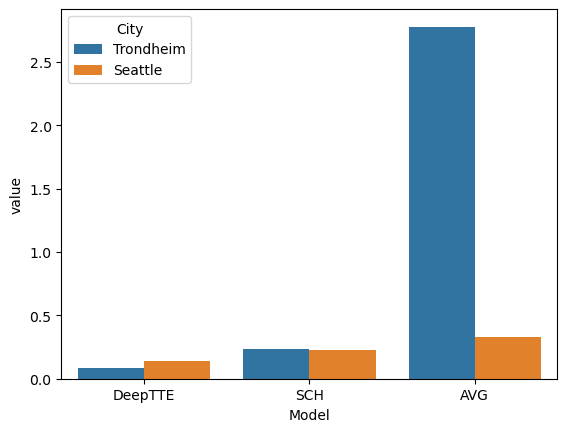

In [10]:
# Plot accuracy across all models
fig, ax = plt.subplots(1,1)
model_performances_df_plot = model_performances_df.sort_values(['value'])
sns.barplot(model_performances_df_plot[model_performances_df_plot['Metric']=='MAPE'], x="Model", y="value", hue="City")
plt.savefig("../plots/model_performances.png", dpi=1800, bbox_inches='tight')

In [11]:
# # List of feature names for understanding importance
# feature_names = ['timeID','weekID','dateID','driverID','dist']
# feature_names = feature_names + [f"lat_{x}" for x in range(128)]
# feature_names = feature_names + [f"lng_{x}" for x in range(128)]

In [12]:
# # Sort importances and names
# atb_features_sorted = [x for _, x in sorted(zip(atb_reg.feature_importances_, feature_names))][::-1]
# atb_importances_sorted = [_ for _, x in sorted(zip(atb_reg.feature_importances_, feature_names))][::-1]
# kcm_features_sorted = [x for _, x in sorted(zip(kcm_reg.feature_importances_, feature_names))][::-1]
# kcm_importances_sorted = [_ for _, x in sorted(zip(kcm_reg.feature_importances_, feature_names))][::-1]

# # Read out names and importances of top n
# print(atb_features_sorted[:10])
# print(kcm_features_sorted[:10])

In [13]:
# # Plot importances
# fig, ax = plt.subplots(1,1)
# plt.bar(atb_features_sorted[:10], atb_importances_sorted[:10])
# plt.savefig("../plots/atb_gbdt_importances.png", dpi=1800, bbox_inches='tight')

In [14]:
# # Plot importances
# fig, ax = plt.subplots(1,1)
# plt.bar(kcm_features_sorted[:10], kcm_importances_sorted[:10])
# plt.savefig("../plots/kcm_gbdt_importances.png", dpi=1800, bbox_inches='tight')

In [15]:
# # Plot importances
# fig, ax = plt.subplots(1,1)
# plt.bar(atb_features_sorted[1:], atb_importances_sorted[1:])
# plt.savefig("../plots/atb_gbdt_non_dist_importances.png", dpi=1800, bbox_inches='tight')

In [16]:
# # Plot importances
# fig, ax = plt.subplots(1,1)
# plt.bar(kcm_features_sorted[1:], kcm_importances_sorted[1:])
# plt.savefig("../plots/kcm_gbdt_non_dist_importances.png", dpi=1800, bbox_inches='tight')